In [1]:
import json
from pathlib import Path
from itertools import permutations
from multiprocessing import cpu_count, Manager, Pool

import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

from classes import Preprocess

# Disables no GPU warning
# Comment out to see warning or use GPU
import jax
jax.config.update('jax_platform_name', 'cpu')

from classes.environment import Env

PATH = Path.cwd()

In [2]:
raw = Preprocess(PATH.joinpath('asset_data', 'TBT_TBF_data.csv'), residual_num=7)
data = raw.process()

In [3]:
def sniper(state_1, state_2, env, start_state):
    state = start_state
    done = False
    all_rewards = list()
    while not done:
        if state[0] == state_1:
            state, reward, done, _ = env.step(0)
        elif state[0] == state_2:
            state, reward, done, _ = env.step(1)
        else:
            state, reward, done, _ = env.step(2)
        all_rewards.append(reward)
    return all_rewards

In [4]:
def imap_sniper(states):
    env = Env(data, steps=2340//2)
    mappings = env.mapping
    
    long = mappings[states[0]]
    short = mappings[states[1]]
    
    rewards = list()
    for _ in trange(5, leave=False, position=1):
        rewards.append(sniper(long, short, env, env.reset()))
        
    final = np.array(rewards)
    
    strategy_rewards[str((states[0], states[1]))] = final[:, -1].mean()

In [5]:
# This takes a while to run, ~2.5 hrs on 15 processes

pairs = list(permutations(Env.get_mapping().keys(), 2))

num_procs = cpu_count()-1
chunk = 2
print('Number of processes:', num_procs)

procs = list()
manager = Manager()
strategy_rewards = manager.dict()

print('Creating pool')
pool = Pool(processes=num_procs)

print('Start processing')
for _ in tqdm(pool.imap_unordered(imap_sniper, pairs, chunksize=chunk), total=len(pairs)//chunk, smoothing=0.1):
    pass

strategy_rewards = dict(strategy_rewards)

# Order strategy_rewards from largest to smallest
strategy_rewards = {k: v for k, v in sorted(strategy_rewards.items(), key=lambda item: -item[1])}
with open('intermediate_data/TBT_TBF_9_242728_sniper_pairs.json', 'w') as file:
    json.dump(strategy_rewards, file)

Number of processes: 15
Creating pool
Start processing


In [6]:
try:
    strategy_rewards
except NameError:
    import json
    with open('intermediate_data/TBT_UBT_9_242728_sniper_pairs.json') as file:
        strategy_rewards = json.load(file)

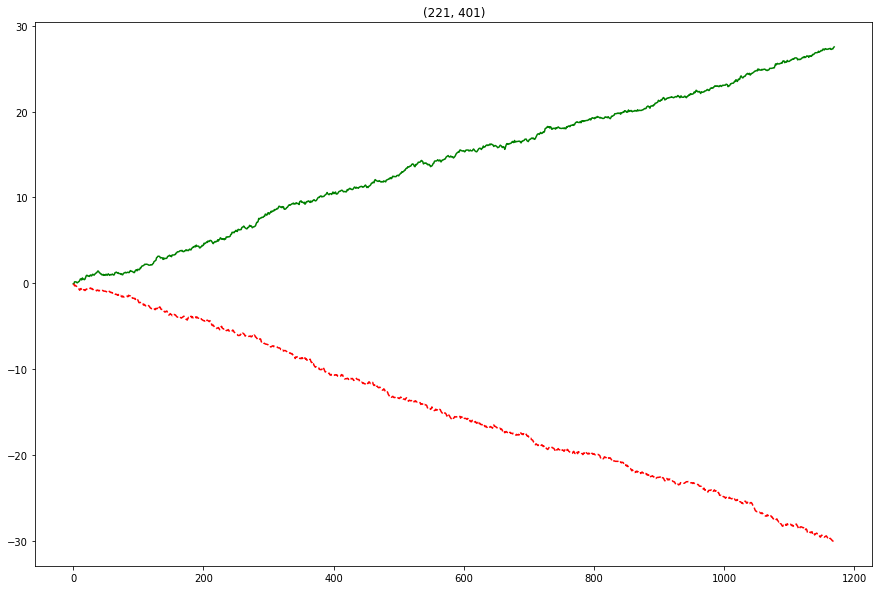

In [10]:
key = list(strategy_rewards.keys())[0]
s1 = key[2:5]
s2 = key[9:12]
env = Env(data, steps=2340//2)
mappings = env.mapping
plt.figure(figsize=(15, 10))

rewards1 = np.array([sniper(mappings[s1], mappings[s2], env, env.reset()) for _ in range(10)])
rewards2 = np.array([sniper(mappings[s2], mappings[s1], env, env.reset()) for _ in range(10)])

plt.plot(rewards1.mean(axis=0), 'g-')
plt.plot(rewards2.mean(axis=0), 'r--')
    
plt.title(f'({s1}, {s2})')
plt.plot()
plt.savefig('figures/top_performing_single_sniper.png', format='png')

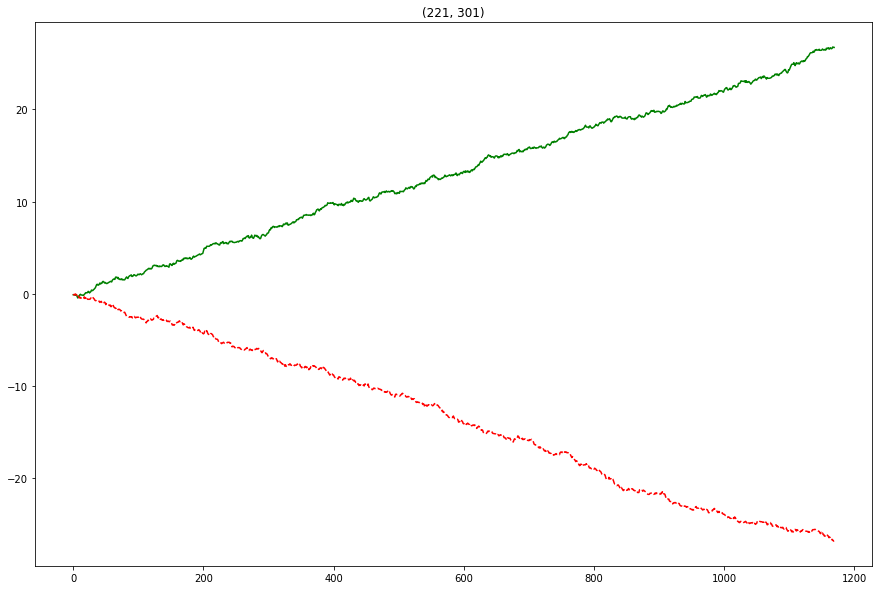

In [11]:
key = list(strategy_rewards.keys())[-1]
s1 = key[9:12]
s2 = key[2:5]
env = Env(data, steps=2340//2)
mappings = env.mapping
plt.figure(figsize=(15, 10))

rewards1 = np.array([sniper(mappings[s1], mappings[s2], env, env.reset()) for _ in range(10)])
rewards2 = np.array([sniper(mappings[s2], mappings[s1], env, env.reset()) for _ in range(10)])

plt.plot(rewards1.mean(axis=0), 'g-')
plt.plot(rewards2.mean(axis=0), 'r--')
    
plt.title(f'({s1}, {s2})')
plt.plot()
plt.savefig('figures/bottom_performing_single_sniper.png', format='png')